In [1]:
%pip install pandas statsmodels matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
# Calculating forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna

In [3]:
# Load your data
# Assuming you have a CSV file with columns: 'date', 'dengue_patient_count', 'precipitation', 'wind_speed', 'temperature'
original_df = pd.read_csv('Kurunegala_df.csv', parse_dates=['Date'], index_col='Date')

In [4]:
if "Predicted" in original_df.columns:
    original_df.drop(['Predicted'],axis=1, inplace=True)

#### Data Transformation

In [5]:
df = original_df.sort_values('Date').copy()
df.shape

(210, 10)

In [6]:
# Check the first few rows of the dataframe
df.drop(columns=['station_name','Year','Month'], inplace=True)

# Combine 'TMPMAX' and 'TMPMIN' into 'TMPAVG'
df['TMPAVG'] = df[['TMPMAX', 'TMPMIN']].mean(axis=1)

# Combine 'wind_speed_8_30am' and 'wind_speed_17_30pm' into 'wind_speed_avg'
df['wind_speed_avg'] = df[['wind_speed_8_30am', 'wind_speed_17_30pm']].mean(axis=1)

# Drop the original columns if no longer needed
df = df.drop(columns=['TMPMAX', 'TMPMIN', 'wind_speed_8_30am', 'wind_speed_17_30pm'])

In [7]:
print(f"shape = {df.shape}\n")
print(df.head())
print(df.describe())

shape = (210, 5)

             humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                  
2007-01-01  80.851852      32.000000        60   25.55            2.80
2007-02-01  79.875000      24.400001        20   27.00            2.00
2007-03-01  78.230769      55.100002        25   28.85            1.60
2007-04-01  90.269231     170.199998        22   27.95            1.54
2007-05-01  83.703704      53.000000        12   28.85            3.45
         humidity  precipitation     patients      TMPAVG  wind_speed_avg
count  210.000000     210.000000   210.000000  210.000000      210.000000
mean    77.684663     174.302095   184.438095   27.744574        3.458861
std      8.416085     153.227132   270.614768    1.073244        2.289252
min     52.900000       0.000000     1.000000   24.450000        0.250000
25%     72.882292      64.725001    64.000000   27.053017        1.800000
50%     78.810489     140.049999   113.00

### Spliting of Datasets

In [8]:
# Splitting the data into training and testing sets
train_data = df[:'2020']      # train model with data till 2020
test_data = df['2021':].copy()   # test dataset 2021-2023

print(train_data.tail(5))
print(test_data.head(5))
print(test_data.tail(5))

            humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                 
2020-08-01     76.20      83.000000        73   28.40             2.9
2020-09-01     82.30     370.500001        35   27.30             2.7
2020-10-01     71.50      52.399999        28   29.05             2.1
2020-11-01     75.60     276.099996        20   27.35             0.8
2020-12-01     83.55     195.700001        32   26.40             1.3
             humidity  precipitation  patients  TMPAVG  wind_speed_avg
Date                                                                  
2021-01-01  82.500000     158.899999       107   26.50            1.20
2021-02-01  70.700000       3.600000        42   30.00            2.45
2021-03-01  73.400000      66.600000       111   28.70            1.85
2021-04-01  84.618462     164.999998       144   29.15            1.60
2021-05-01  84.150000     467.900000       101   28.20            1.80
             

### Model Training with Optomized HyperParameters 
##### Best parameters: {'p': 1, 'd': 0, 'q': 0, 'P': 2, 'D': 0, 'Q': 1}

In [9]:
# Defining the SARIMAX model
tuned_model = sm.tsa.SARIMAX(train_data['patients'],
        exog=train_data[['humidity','precipitation','TMPAVG','wind_speed_avg']],
        order=(1, 0, 0),
                       seasonal_order=(2, 0, 1, 12),  # s =12
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fitting the model    
final_model_fit = tuned_model.fit(disp=False)

c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
# Making predictions for test dataset
testdata_forecast = final_model_fit.get_forecast(steps=len(test_data), exog=test_data.drop(['patients'],axis=1))
final_forecast_ci = testdata_forecast.conf_int()

In [11]:
test_data.loc[:, 'Predicted'] = testdata_forecast.predicted_mean
test_data['Predicted'] = test_data['Predicted'].clip(lower=0)

#### Visulization

In [12]:
# Ensure the test dataset only contains data up to 2023
test_data_2023 = test_data[test_data.index <= '2023-12-31']
test_data_2024 = test_data[test_data.index > '2023-12-31']

In [13]:
test_data_2023.tail()

,humidity,precipitation,patients,TMPAVG,wind_speed_avg,Predicted
Date,,,,,,
2023-08-01,72.35,46.499999,199,29.7,9.45,237.095984
2023-09-01,85.10,310.800001,126,27.5,6.75,209.487329
2023-10-01,87.20,489.099998,91,27.6,4.25,184.863255
2023-11-01,87.15,538.400007,101,27.9,3.20,177.099092
2023-12-01,85.75,205.400001,317,27.4,4.85,215.379853


RMSE for test dataset : 61.065591937234196
RMSE for 2024 dataset : 134.26066141038666


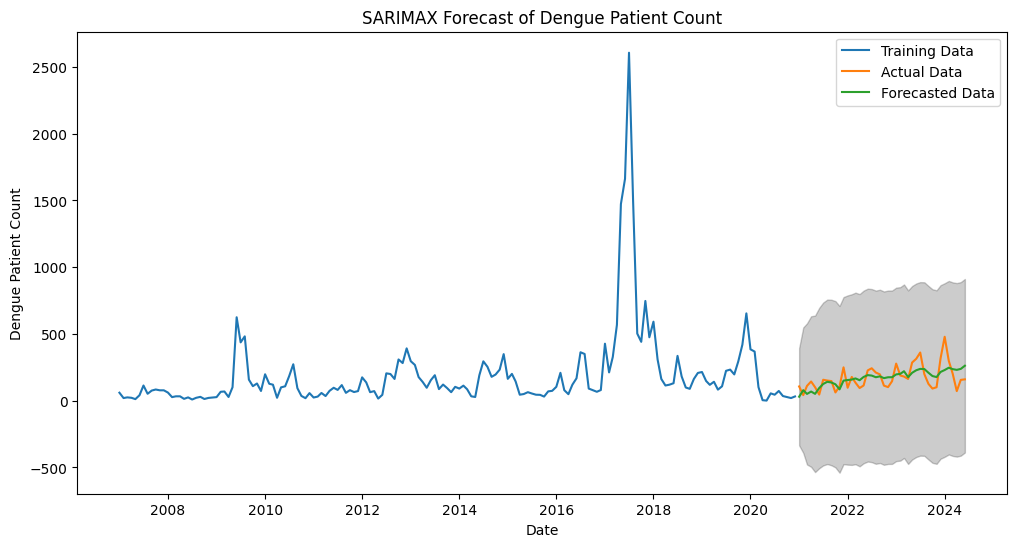

In [14]:
test_mse = mean_squared_error(test_data_2023['patients'], test_data_2023['Predicted'])
final_rmse = np.sqrt(test_mse)
print(f"RMSE for test dataset : {final_rmse}")

test_mse = mean_squared_error(test_data_2024['patients'], test_data_2024['Predicted'])
_rmse = np.sqrt(test_mse)
print(f"RMSE for 2024 dataset : {_rmse}")

# Plotting the results
plt.figure(figsize=(12, 6))

# plot the actual train dataset
plt.plot(train_data.index, train_data['patients'], label='Training Data')

# plot the test dataset and predictions
plt.plot(test_data.index, test_data['patients'], label='Actual Data')
plt.plot(test_data.index, testdata_forecast.predicted_mean, label='Forecasted Data')
plt.fill_between(test_data.index, final_forecast_ci.iloc[:, 0], final_forecast_ci.iloc[:, 1], color='k', alpha=0.2)


plt.xlabel('Date')
plt.ylabel('Dengue Patient Count')
plt.title('SARIMAX Forecast of Dengue Patient Count')
plt.legend()
plt.show()

In [15]:
# Merge the predictions back into the original DataFrame
original_df['Predicted'] = test_data['Predicted']

# Save the updated dataframe to CSV
original_df.to_csv('Kurunegala_df.csv')